In [3]:
pwd

'C:\\Users\\asy10\\Desktop\\수업\\기계학습특강\\논문구현\\transformer'

## 말뭉치 데이터 전처리

In [4]:
import json
import csv
 
# 일상생활및구어체_영한_train_set.json' 파일을 읽어서 train_set.csv 파일에 저장
with open('./data/일상생활및구어체_영한_train_set.json', 'r', encoding = 'utf-8') as input_file, open('./data/train_set.csv', 'w', newline = '',encoding = 'utf-8') as output_file :
    data = json.load(input_file)

    f = csv.writer(output_file)
    
    # csv 파일에 header 추가
    f.writerow(['en', 'ko'])
    
    for line in data['data']:
        f.writerow([line['en'],line['ko']])

In [5]:
# 일상생활및구어체_영한_valid_set.json' 파일을 읽어서 test_set.csv 파일에 저장
with open('./data/일상생활및구어체_영한_valid_set.json', 'r', encoding = 'utf-8') as input_file2, open('./data/test_set.csv', 'w', newline = '',encoding = 'utf-8') as output_file2 :
    data2 = json.load(input_file2)

    f = csv.writer(output_file2)
    
    # csv 파일에 header 추가
    f.writerow(['en', 'ko'])
    
    for line in data2['data']:
        f.writerow([line['en'],line['ko']])

In [6]:
import pandas as pd

train_data = pd.read_csv('./data/train_set.csv',encoding='utf-8')
test_data = pd.read_csv('./data/test_set.csv',encoding='utf-8')

In [7]:
train_data.head()

,en,ko
0,"I'm glad to hear that, and I hope you do consi...","그 말을 들으니 기쁘고, 저희와 거래하는 것을 고려해 주셨으면 합니다."
1,"I'm definitely thinking about it, but I have s...","확실히 생각하고 있습니다만, 몇 가지 여쭤보고 싶은 게 있어요."
2,"In today's world, one in every five families h...",오늘날 세계 5가구 중 1가구는 고양이나 개 또는 둘 다를 키우고 있습니다.
3,"When you tell them, we'll take care of their c...","그들에게 말하면, 저희가 그 아이들을 돌볼 것입니다."
4,"OK, how about for swimming?","좋아요, 수영은 어떤가요?"


In [9]:
print('train data : ', len(train_data))
print('test data : ', len(test_data))

train data :  1200307
test data :  150038


### Tokenizer 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time


from torchtext.legacy import data 
from konlpy.tag import Okt

tokenizer = Okt()

In [11]:
print(torch.__version__)

1.10.0


In [51]:
def tokenize_kor(text):
    """한국어를 tokenizer해서 단어들을 리스트로 만듦"""
    return [text_ for text_ in tokenizer.morphs(text)]

def tokenize_en(text):
    """영어를 split tokenizer해서 단어들을 리스트로 만듦"""
    return [text_ for text_ in text.split()]

# 필드 정의(train)

train_SRC =data.Field(train_data,tokenize = tokenize_kor,
                init_token = '<sos>',
                eos_token = '<eos>',batch_first = True,lower = True)

train_TRG =data.Field(train_data,tokenize = tokenize_en,
                init_token = '<sos>',
                eos_token = '<eos>',batch_first = True,
                lower = True)

In [52]:
test_SRC =data.Field(test_data,tokenize = tokenize_kor,
                init_token = '<sos>',
                eos_token = '<eos>',batch_first = True,lower = True)

test_TRG =data.Field(test_data, tokenize = tokenize_en,
                init_token = '<sos>',
                eos_token = '<eos>',batch_first = True,
                lower = True)

In [13]:
train_shuffled= train_data.sample(frac=1).reset_index(drop=True)
test_shuffled = test_data.sample(frac=1).reset_index(drop=True)

In [14]:
train_shuffled.shape

(1200307, 2)

In [15]:
test_shuffled.shape

(150038, 2)

In [16]:
#train 
from sklearn.model_selection import KFold
train_ = train_shuffled[:100000]

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

for i,(trn_idx,val_idx) in enumerate(kf.split(train_['ko'])):
    trn = train_.iloc[trn_idx]
    val = train_.iloc[val_idx]

In [19]:
#test
test_ = test_shuffled[:50000]

In [18]:
print('df size : ' ,len(train_))
print('trn size: ',len(trn))
print('val size: ',len(val))
print('val size: ',len(test_))

df size :  100000
trn size:  80000
val size:  20000
val size:  50000


In [21]:
path = './data/'
trn.to_csv(path + 'trn.csv',index = False)
val.to_csv(path + 'val.csv',index = False)
test_.to_csv(path + 'test.csv',index = False)

In [53]:
from torchtext.legacy.data import TabularDataset

train_data, validation_data =TabularDataset.splits(
     path='./data/', train='trn.csv',validation= 'val.csv', format='csv',
        fields=[('ko', train_SRC), ('en', train_TRG)], skip_header=True)

In [54]:
test_data = TabularDataset(path='./data/test.csv', format='csv',fields=[('ko', test_SRC), ('en', test_TRG)], skip_header=True)

In [55]:
print(vars(train_data.examples[30])['ko'])
print(vars(train_data.examples[30])['en'])

['you', "'", 'll', 'have', 'to', 'do', 'a', 'backpacking', 'trip', '.']
['배낭', '여행을', '하셔야', '해요.']


In [56]:
print(vars(test_data.examples[30])['ko'])
print(vars(test_data.examples[30])['en'])

['i', 'have', 'been', 'informed', 'that', '10%', 'of', 'the', 'products', 'we', 'received', 'from', 'you', 'last', 'month', 'were', 'defective', '.']
['지난', '달에', '귀사에서', '보내', '주신', '제품의', '10%가', '결함이', '있다는', '보고를', '받았습니다.']


In [57]:
train_SRC.build_vocab(train_data, min_freq = 2)
train_TRG.build_vocab(train_data, min_freq = 2)

print(f"len(SRC): {len(train_SRC.vocab)}")
print(f"len(TRG): {len(train_TRG.vocab)}")

len(SRC): 12816
len(TRG): 34580


In [58]:
test_SRC.build_vocab(test_data, min_freq = 2)
test_TRG.build_vocab(test_data, min_freq = 2)

print(f"len(SRC): {len(test_SRC.vocab)}")
print(f"len(TRG): {len(test_TRG.vocab)}")

len(SRC): 11144
len(TRG): 27010


In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
BATCH_SIZE = 128

cuda:0


### Dataset 정의

In [49]:
train_iterator, valid_iterator, train_iterator = BucketIterator.splits((train_data, validation_data, test_data),
                                                                              batch_size=BATCH_SIZE,
                                                                              device=device)


## Embedding 

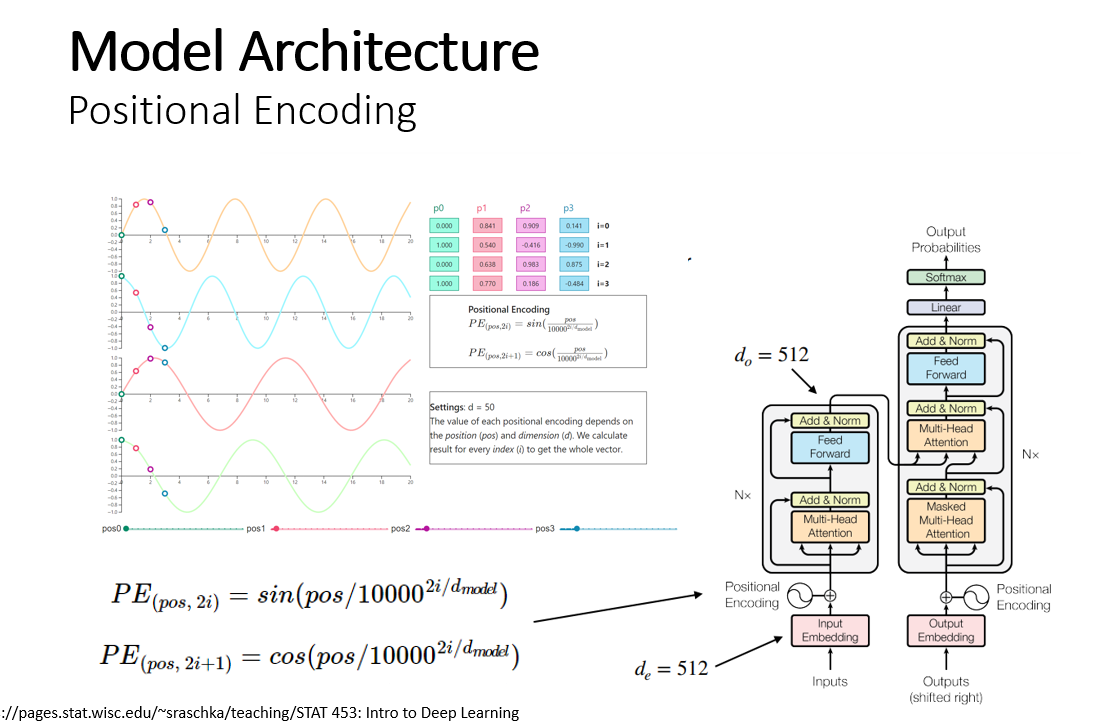

In [75]:
Image("./image/pe.png")

In [83]:
# 입력 문장 임베딩 
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super(TokenEmbedding, self).__init__(vocab_size, d_model, padding_idx=1)
        

In [81]:
# 문장 내에서 위치 정보를 포함시킴 
class PostionalEncoding(nn.Module):

    def __init__(self, d_model, max_len, device):
        
        super(PostionalEncoding, self).__init__()
        
        # 입력 임베딩과 사이즈를 같게 해준다. 
        
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False # 그라디언트 계산 안함
        
        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1) # 2차원을 축소해서 만든 1차원은 문장의 단어 위치를 나타냄 
        
        _2i = torch.arange(0, d_model, step=2, device=device).float()
        
        # 'i' 는 d_model의 인덱스이다. 
        # 'step=2'는 2 * i 를 연산해서 d_model의 짝수 인덱스, 홀수 인덱스를 나타내기 위해 선언 
        
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        
    def forward(self, x):
        
        #self.encoding : [max_len = 512, d_model = 512]
        
        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]
        
        return self.encoding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # tok_emb : [128, 30, 512]
        

In [82]:
class TransformerEmbedding(nn.Module):
    # TokenEmbedding + PostionalEncoding 
    
    def __init__(self, vocab_size, d_model, max_len, drop_prob, device):
        super(TransformerEmbedding, self).__init__()
        self.tok_emb = TokenEmbedding(vocab_size, d_model)
        self.pos_emb = PostionalEncoding(d_model, max_len, device)
        self.drop_out = nn.Dropout(p=drop_prob)
    
    def forward(self, x):
        tok_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(x)
        
        return self.drop_out(tok_emb + pos_emb)
    

In [61]:
from IPython.display import Image

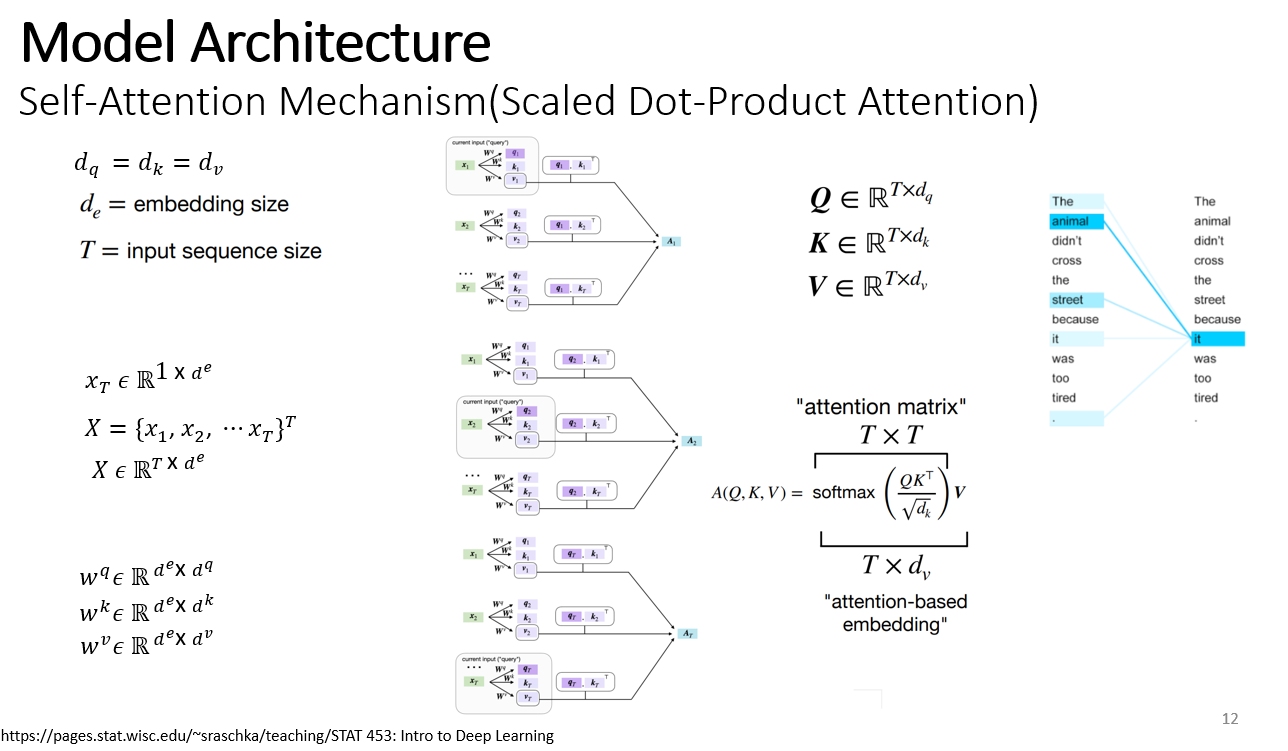

In [66]:
Image("./image/sca-attn.png")

## Layer

In [84]:
import torch.nn as nn

class ScaleDotProductAttention(nn.Module):
    """
    
    Query : 주어진 문장에서 집중하는 것 (인코더)
    Key : 매 문장마다 query와의 관계를 확인 (디코더)
    Value : key와 동일 (디코더)
    """
    
    def __init__(self):
        super(ScaleDotProductAttention, self).__init__()
        self.softmax = nn.softmax(dim=-1)
        
    def forward(self, q, k, v, mask=None, e=1e-12):
        # 입력은 4차원 텐서 
        # [batch_size, n_heads, sequence_len, head_dim]
        batch_size, n_heads, seq_len, head_dim = k.size()
        
        
        # 1. query와 k^T를 내적해서 유사도를 구한다. 
        k_t = k.transpose(2,3)
        score = (q @ k_t) / math.sqrt(d_tensor) #기울기 소실 방지 
        
        # 2. 마스킹이 존재하면 스코어 값에 0 채워 넣기 
        if mask is not None:
            score = score.mask_fill(mask == 0, -10000)
            
        # 3. 소프트 맥스 취하기 
        score = self.softmax(score)
        
        # 4. 어텐션 스코어와 Value와 곱하기 => 최종 출력 
        
        v = score @ v
        
        # 각 Query에 대해 모델은 어떤 Key, Value 입력에 attention 해야하는지 학습한다. 
        return v, score 
        
        

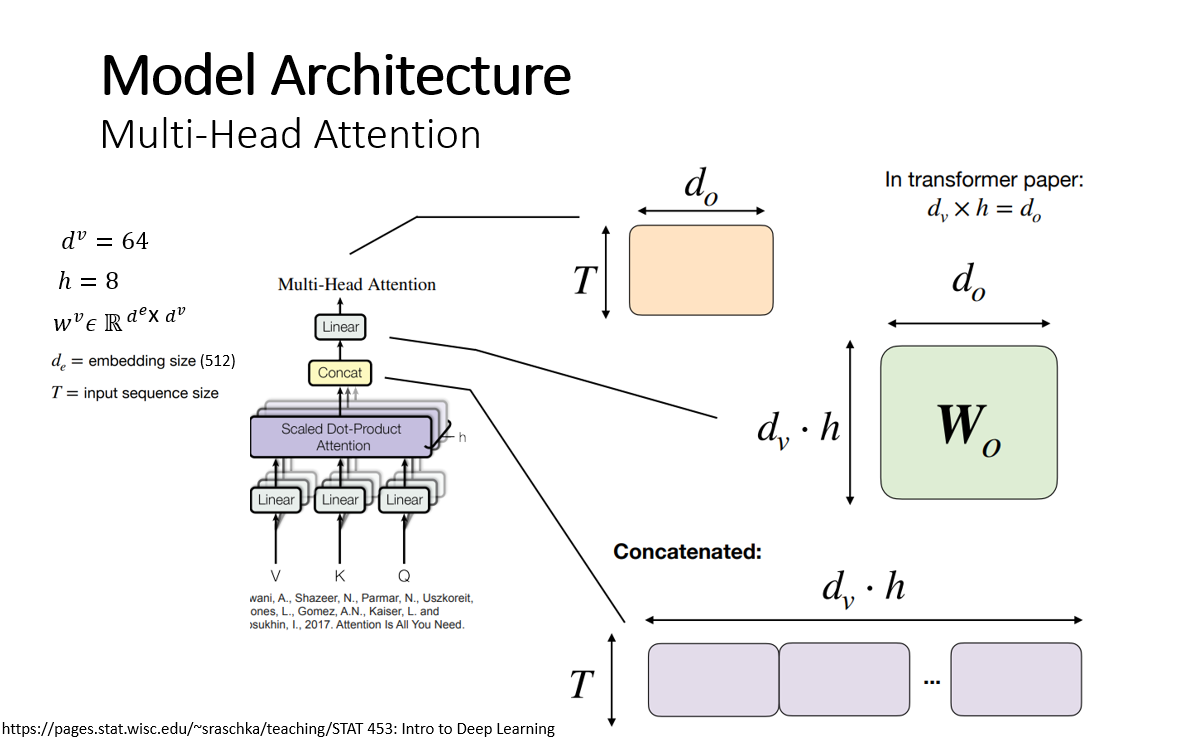

In [65]:
Image("./image/mul.png")

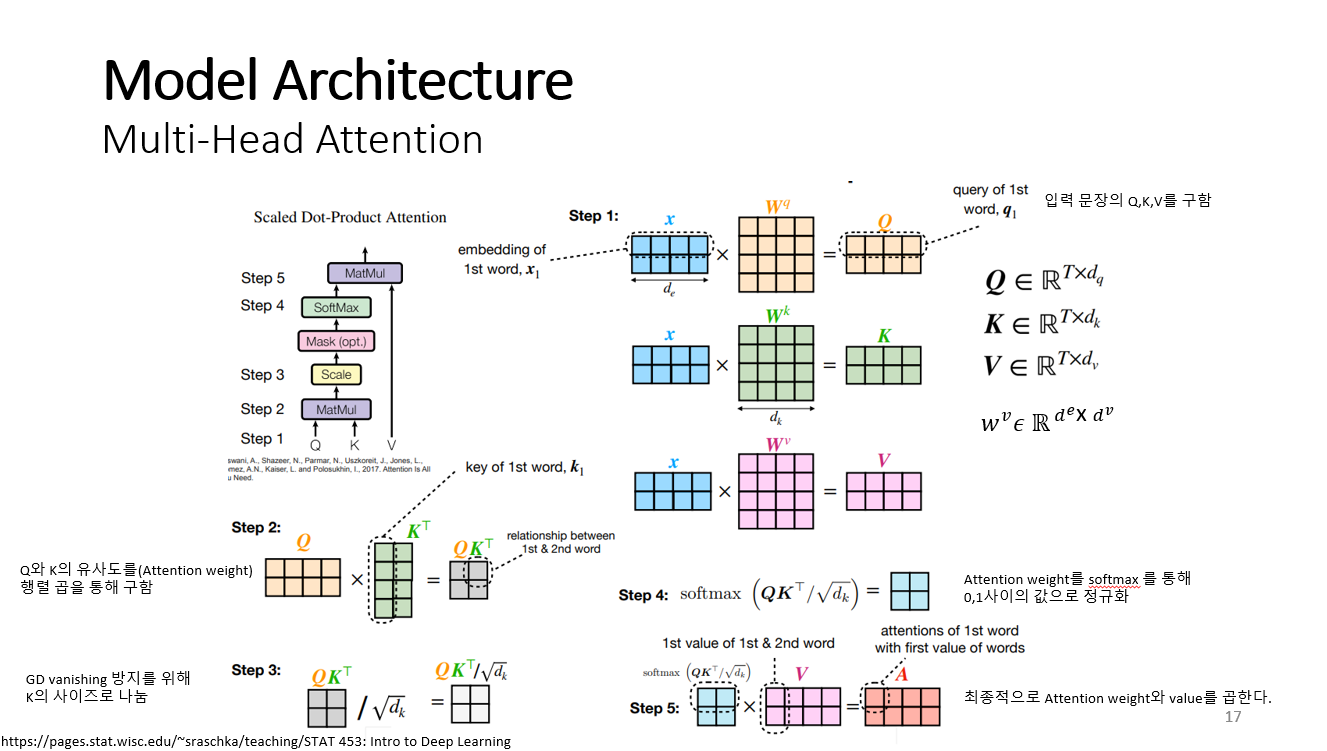

In [67]:
Image("./image/attn2.png")

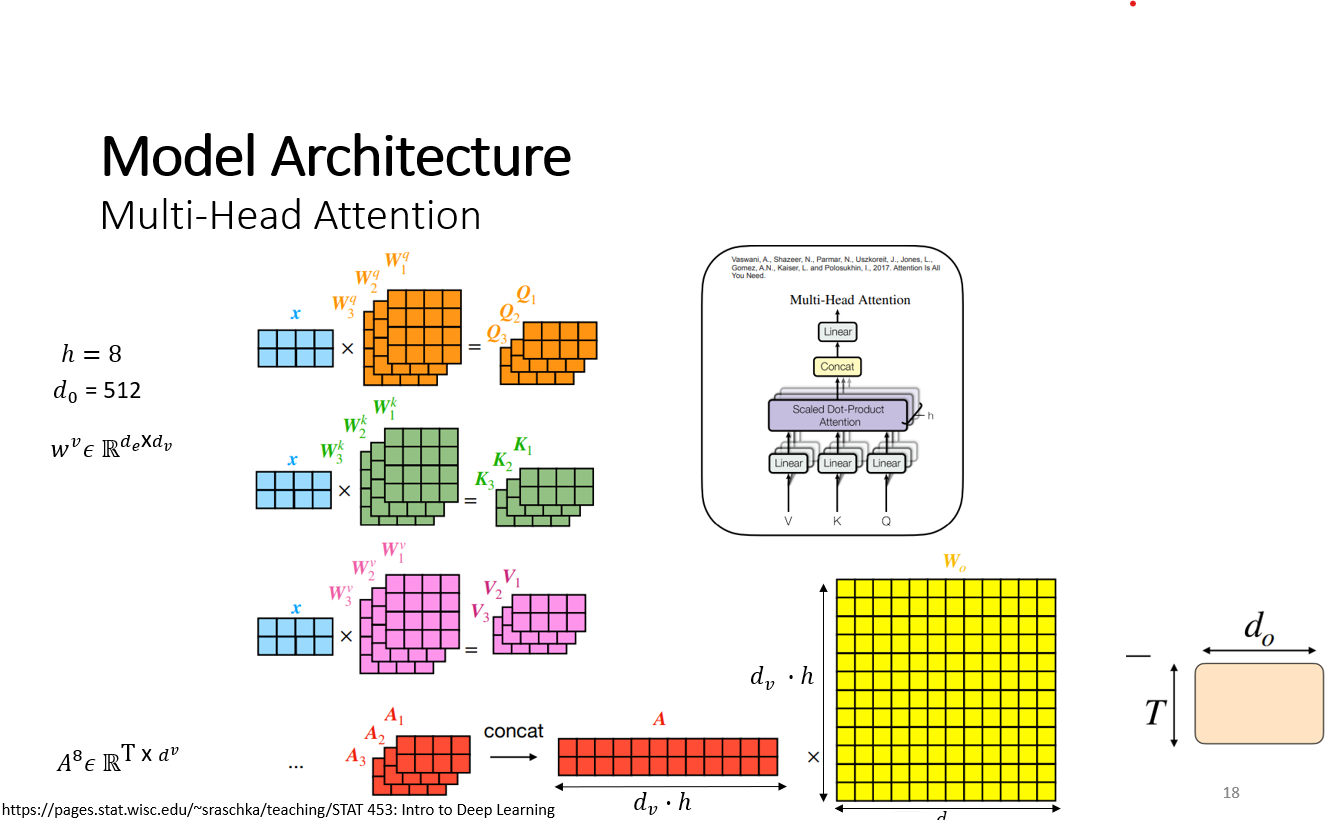

In [69]:
Image("./image/attn3.png")

In [71]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)
    def forward(self, q, k, v, mask=None):
        
        # 1. 입력과 각각 query 가중치 행렬, key 가중치 행렬, value 가중치 행렬을 곱해서 
        # query , key, value를 구한다. 
        
        # q: [batch_size, query_len, d_model]
        # k: [batch_size, key_len, d_model]
        # v: [batch_size, value_len, d_model]
        
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)
        
        # 2. n_heads 수 만큼 텐서를 자른다. 
        
        q, k, v = self.split(q), self.split(k), self.split(v)
        
        # q: [batch_size, n_head, query_len, d_model]
        # k: [batch_size, n_head, key_len, d_model]
        # v: [batch_size, n_head, value_len, d_model]
        
        # 3. scale dot product를 통해서 attention 을 구한다. 
        
        out, attention = self.attention(q, k, v, mask=mask)
        
        # 4. concat 후 linear layer로 통과 
        # multihead-attention레이어 안에서 scaled Dot-Product attetion 레이어에서 나온 Q,K,V 들을 concat함. 
        # concat한 것의 출력은 sequence_size x (n_heads x d_model)
        out = self.concat(out)
        out = self.w_concat(out)
        
        return out
    def split(self, tensor):
        
        """
        입력 텐서 차원 : [batch_size, sequnece_length, d_model]
        
        함수 통과 후 차원 : [batch_size, head, sequnence_length, d_tensor]
        
        """
        batch_size, seq_len, d_model = tensor.size()
        
        d_tensor = d_model // self.n_head
        
        # n_head(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
        tensor = tensor.view(batch_size, seq_len, self.n_head, d_tensor).transpose(1,2)
        
        return tensor
    def concat(self, tensor):
        
        """
        입력 텐서 차원 : [batch_size, head, sequnence_length, d_tensor]
        
        함수 통과 후 차원 : [batch_size, sequnence_length, d_model]
        
        """
        
        bath_size, head, seq_len, d_tensor = tensor.size()
        d_model = head * d_tensor
        
        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        return tensor

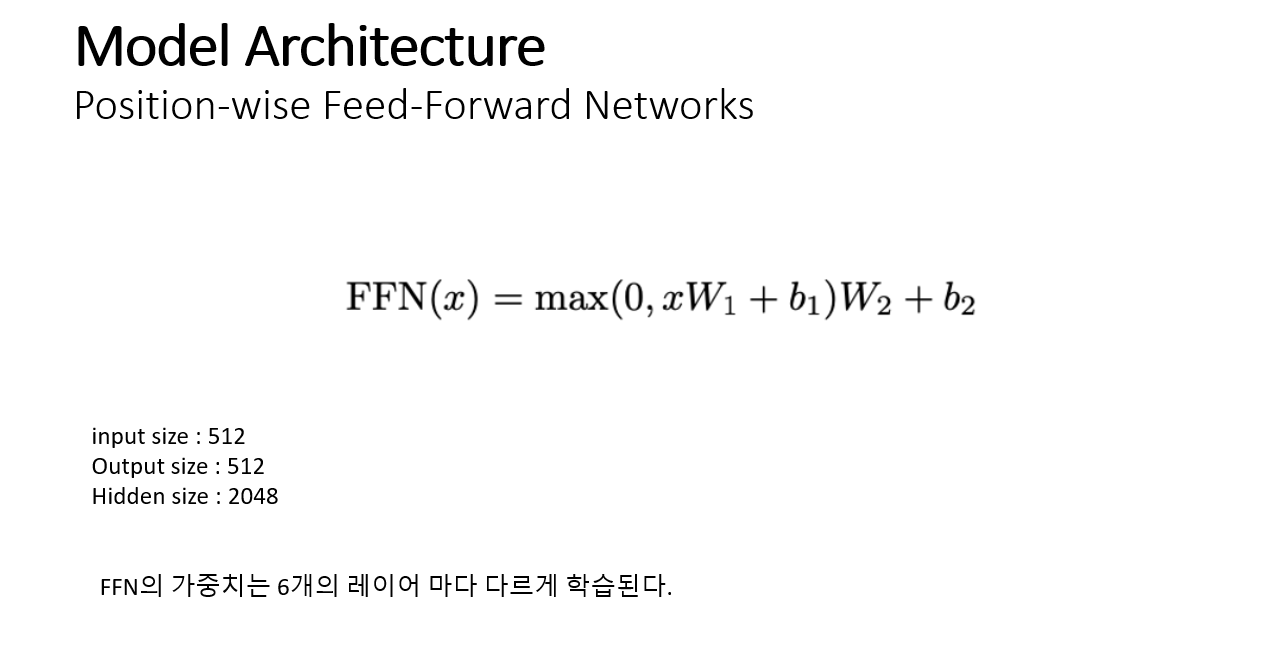

In [74]:
Image("./image/ffw.png")

In [72]:
class PositionwiseFeedForward(nn.Module):
    
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)
        
    def forward(self, x):
        
        # x 차원 : [batch_size, seq_len, d_model]
        
        x = self.linear1(x)
        
        # x 차원 : [batch_size, seq_len, hidden]
        x = self.relu(x)
        
        x = self.dropout(x)
        
        # x 차원 : [batch_size, seq_len, d_model]
        x = self.linear2(x)
        
        return x     

    

## model

In [85]:
class Encoder(nn.Module):
    def __init__(self, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        
        self.emb = TransformerEmbedding(vocab_size=enc_voc_size,
                                        d_model=d_model,
                                        max_len=max_len,
                                        drop_prob=drop_prob,
                                        device=device)
        
        self.layers = nn.ModuleList([EncoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])
        def forward(self, x, s_mask):
            x = self.emb(x)
            
            for layer in self.layers:
                x = layer(x, s_mask)
                
            # 마지막 레이어의 출력을 반환한다.     
            return x

In [87]:
class Decoder(nn.Module):
    def __init__(self, dec_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        self.emb = TransformerEmbedding(d_model=d_model,
                                        drop_prob=drop_prob,
                                        max_len=max_len,
                                        vocab_size=dec_voc_size,
                                        device=device)

        self.layers = nn.ModuleList([DecoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

        self.linear = nn.Linear(d_model, dec_voc_size) # 트랜스 포머 최종 출력 레이어 

    # 인코더의 출력(enc_src)을 어텐션 하는 구조 
    def forward(self, trg, enc_src, trg_mask, src_mask):
        

        trg = self.emb(trg)

        # trg : [batch_size, trg_len, d_model]
        
        for layer in self.layers:
            trg = layer(trg, enc_src, trg_mask, src_mask)
        
        # pass to LM head

        output = self.linear(trg)
        return output 

In [88]:
class Transformer(nn.Module):

    def __init__(self, src_pad_idx, trg_pad_idx, trg_sos_idx, enc_voc_size, dec_voc_size, d_model, n_head, max_len,
                 ffn_hidden, n_layers, drop_prob, device):
        super().__init__()
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx
        self.device = device
        self.encoder = Encoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               enc_voc_size=enc_voc_size,
                               drop_prob=drop_prob,
                               n_layers=n_layers,
                               device=device)

        self.decoder = Decoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               dec_voc_size=dec_voc_size,
                               drop_prob=drop_prob,
                               n_layers=n_layers,
                               device=device)

    def forward(self, src, trg):
        
        # src: [batch_size, src_len]
        
        src_mask = self.make_pad_mask(src, src)
        
        

        src_trg_mask = self.make_pad_mask(trg, src)

        # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
        trg_mask = self.make_pad_mask(trg, trg) * \
                   self.make_no_peak_mask(trg, trg)

        enc_src = self.encoder(src, src_mask)
        output = self.decoder(trg, enc_src, trg_mask, src_trg_mask)
        return output

    def make_pad_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)

        # batch_size x 1 x 1 x len_k
        k = k.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # batch_size x 1 x len_q x len_k
        k = k.repeat(1, 1, len_q, 1)

        # batch_size x 1 x len_q x 1
        q = q.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(3)
        # batch_size x 1 x len_q x len_k
        q = q.repeat(1, 1, 1, len_k)

        mask = k & q
        return mask

    def make_no_peak_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)

        # len_q x len_k
        mask = torch.tril(torch.ones(len_q, len_k)).type(torch.BoolTensor).to(self.device)

        return mask

In [90]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, s_mask):
        # 1. compute self attention
        # x: [batch_size, x_len, d_model]
        # s_mask: [batch_size, x_len]

        # 하나의 입력값을 통해 query, key, value 값 생성 , decoder는 다름.
        _x = x
        x = self.attention(q=x, k=x, v=x, mask=s_mask)
        
        # 2. add and norm
        x = self.dropout1(x)
        x = self.norm1(x + _x)
        
        # 3. positionwise feed forward network
        _x = x
        x = self.ffn(x)
      
        # 4. add and norm
        x = self.dropout2(x)
        x = self.norm2(x + _x)
        return 

In [91]:
class DecoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.enc_dec_attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, dec, enc, t_mask, s_mask):
        # 1. compute self attention
        _x = dec
        x = self.self_attention(q=dec, k=dec, v=dec, mask=t_mask)
        
        # 2. add and norm
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        if enc is not None:
            # 3. compute encoder - decoder attention
            # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
            _x = x
            x = self.enc_dec_attention(q=x, k=enc, v=enc, mask=s_mask)
            # x: [batch_size, x_len, d_model]
            
            # 4. add and norm
            x = self.dropout2(x)
            x = self.norm2(x + _x)

        # 5. positionwise feed forward network
        _x = x
        x = self.ffn(x)
        
        # 6. add and norm
        x = self.dropout3(x)
        x = self.norm3(x + _x)
        return x

In [ ]:
model = Transformer(src_pad_idx=src_pad_idx,
                    trg_pad_idx=trg_pad_idx,
                    trg_sos_idx=trg_sos_idx,
                    d_model=d_model,
                    enc_voc_size=enc_voc_size,
                    dec_voc_size=dec_voc_size,
                    max_len=max_len,
                    ffn_hidden=ffn_hidden,
                    n_head=n_heads,
                    n_layers=n_layers,
                    drop_prob=drop_prob,
                    device=device).to(device)